In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df=pd.read_excel('preprocessed_data.xlsx')

In [3]:
df.drop(df.loc[df['language']!='en'].index, inplace=True)

In [4]:
df.shape

(7961, 14)

In [5]:
c = df.group.value_counts()
c = c[c < 200].index
print(c)
print(df.group.nunique() - len(c)+1)

Index(['GRP_3', 'GRP_6', 'GRP_13', 'GRP_24', 'GRP_10', 'GRP_5', 'GRP_14',
       'GRP_4', 'GRP_25', 'GRP_29', 'GRP_18', 'GRP_16', 'GRP_17', 'GRP_7',
       'GRP_31', 'GRP_26', 'GRP_34', 'GRP_40', 'GRP_41', 'GRP_15', 'GRP_20',
       'GRP_33', 'GRP_28', 'GRP_45', 'GRP_22', 'GRP_1', 'GRP_21', 'GRP_11',
       'GRP_47', 'GRP_23', 'GRP_30', 'GRP_60', 'GRP_39', 'GRP_62', 'GRP_27',
       'GRP_37', 'GRP_44', 'GRP_36', 'GRP_50', 'GRP_48', 'GRP_65', 'GRP_53',
       'GRP_55', 'GRP_52', 'GRP_51', 'GRP_46', 'GRP_59', 'GRP_43', 'GRP_42',
       'GRP_66', 'GRP_49', 'GRP_38', 'GRP_63', 'GRP_56', 'GRP_58', 'GRP_68',
       'GRP_69', 'GRP_71', 'GRP_72', 'GRP_57', 'GRP_54', 'GRP_32', 'GRP_35',
       'GRP_67', 'GRP_64', 'GRP_70', 'GRP_61', 'GRP_73'],
      dtype='object')
7


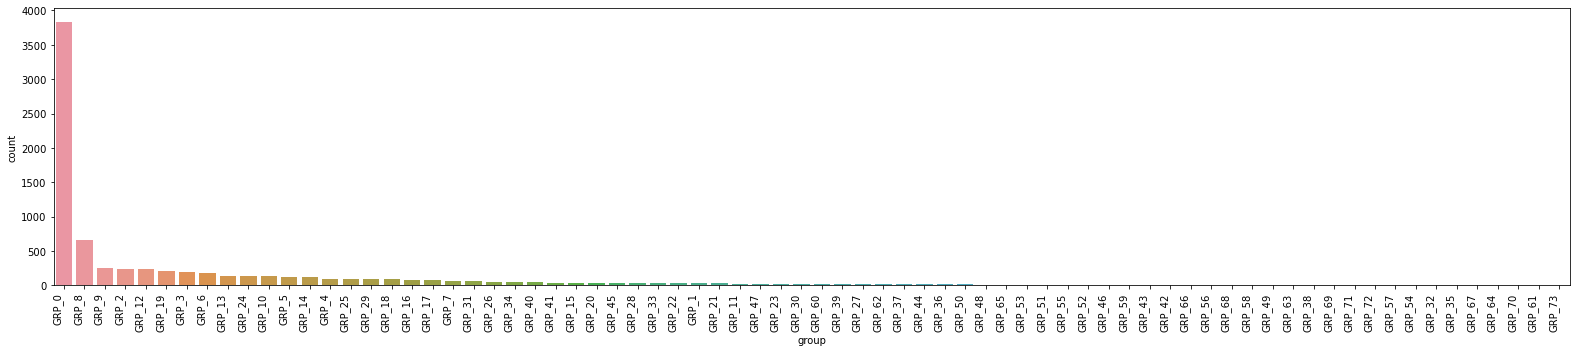

In [6]:
descending_order = df['group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='group', data=df,order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

In [7]:
#convert all categories with less than 200 freq as 'Grouped_Assignment'
df['New_group'] = np.where(df.groupby('group')['group'].transform('size') < 200, 'Grouped_Assignment', df['group'])

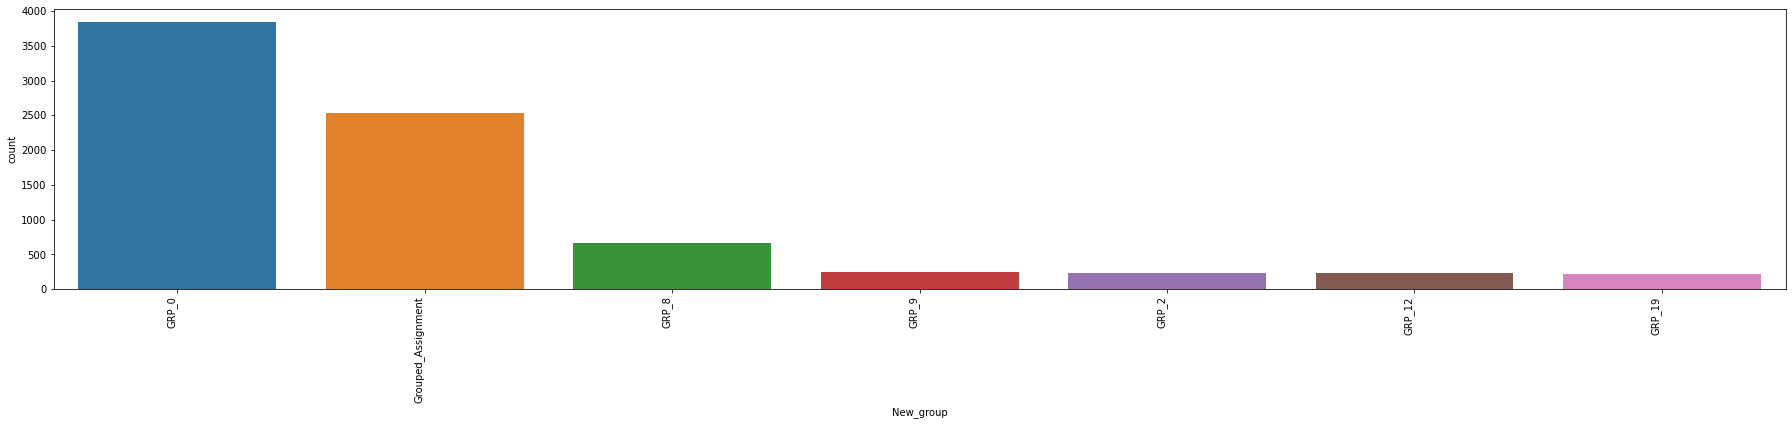

In [8]:
descending_order = df['New_group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(25,6))
#add code to rotate the labels
ax=sns.countplot(x='New_group', data=df,order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

In [9]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, TimeDistributed, Reshape,Dot
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from keras.initializers import Constant
from tensorflow.keras.utils import to_categorical

In [10]:
from sklearn.metrics import accuracy_score

In [11]:
max_features = 10000
maxlen = 40
embedding_size = 200
# define params
#NUM_WORDS = 20000
#EMBEDDING_DIM = 300
#MAX_LEN = 100

In [12]:
train = df.sample(frac=0.60, random_state=99)
test = df.loc[~df.index.isin(train.index), :]

In [13]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train['merged_description'])

In [14]:
X = tokenizer.texts_to_sequences(train['merged_description'])
X = pad_sequences(X, maxlen = maxlen)
y = pd.get_dummies(train['New_group'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", y.shape[1])

Number of Samples: 4777
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  16  28 240]
Number of Labels:  7


In [15]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(list(word_index.keys())[:100])

Found 7268 unique tokens.
['job', 'yes', 'na', 'password', 'ts', 'erp', 'user', 'tool', 'issue', 'scheduler', 'fail', 'company', 'ticket', 'sid', 'reset', 'unable', 'u', 'error', 'access', 'work', 'need', 'account', 'get', 'help', 'email', 'system', 'site', 'login', 'power', 'use', 'hostname', 'circuit', 'outlook', 'network', 'see', 'message', 'update', 'vendor', 'change', 'try', 'check', 'name', 'backup', 'able', 'new', 'server', 'log', 'telecom', 'phone', 'problem', 'type', 'order', 'start', 'call', 'time', 'connect', 'contact', 'open', 'request', 'team', 'lock', 'usa', 'printer', 'report', 'plant', 'send', 'crm', 't', 'attach', 'vpn', 'show', 'window', 'device', 'print', 'engineering', 'schedule', 'create', 'since', 'file', 'maintenance', 'outage', 'event', 'receive', 'screen', 'notify', 'pc', 'management', 'pm', 'skype', 'provider', 'sale', 'cert', 'maint', 'connection', 'resolve', 'platform', 'customer', 'collaboration', 'detail', 'could']


In [16]:
VOCAB_SIZE = len(word_index) + 1
VOCAB_SIZE

7269

In [17]:
EMBEDDING_FILE = 'glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

print('Found %s word vectors.' % len(embeddings))

Found 400000 word vectors.


In [18]:
embedding_dim = 200

embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

In [19]:
model = Sequential()
model.add(Embedding(len(word_index)+1,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=maxlen,
                    trainable=True))

model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64, recurrent_dropout=0.1,return_sequences=True)))
model.add(Bidirectional(LSTM(64, recurrent_dropout=0.1)))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))

model.add(Dense(7, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 200)           1453800   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 40, 200)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 128)           135680    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 4

In [20]:
epochs = 20
batch_size = 128

history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.1)

Epoch 1/20
34/34 [==============================] - 19s 348ms/step - loss: 1.3429 - accuracy: 0.5231 - val_loss: 0.9989 - val_accuracy: 0.6213
Epoch 2/20
34/34 [==============================] - 11s 309ms/step - loss: 0.9690 - accuracy: 0.6381 - val_loss: 0.8848 - val_accuracy: 0.6778
Epoch 3/20
34/34 [==============================] - 10s 307ms/step - loss: 0.8617 - accuracy: 0.6764 - val_loss: 0.8187 - val_accuracy: 0.6925
Epoch 4/20
34/34 [==============================] - 10s 308ms/step - loss: 0.7549 - accuracy: 0.7278 - val_loss: 0.7770 - val_accuracy: 0.7071
Epoch 5/20
34/34 [==============================] - 10s 307ms/step - loss: 0.6754 - accuracy: 0.7592 - val_loss: 0.7382 - val_accuracy: 0.7322
Epoch 6/20
34/34 [==============================] - 10s 307ms/step - loss: 0.5978 - accuracy: 0.7809 - val_loss: 0.7902 - val_accuracy: 0.7197
Epoch 7/20
34/34 [==============================] - 11s 314ms/step - loss: 0.5476 - accuracy: 0.8046 - val_loss: 0.7523 - val_accuracy: 0.7322

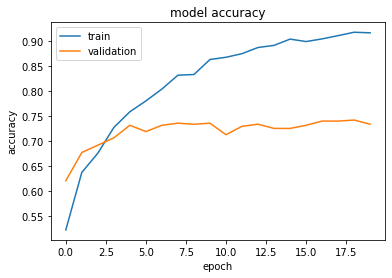

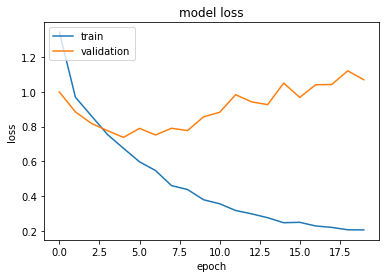

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
X_test = tokenizer.texts_to_sequences(test['merged_description'])
X_test = pad_sequences(X_test, maxlen = maxlen)

In [23]:
le = preprocessing.LabelEncoder()
le.fit(test['New_group'])
y_test=le.transform(test['New_group'])

In [24]:
word_index_test = tokenizer.word_index

In [25]:
y_hat = np.argmax(model.predict(X_test), axis=-1)

In [26]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print(classification_report(y_hat,y_test))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1586
           1       0.53      0.56      0.55        94
           2       0.32      0.31      0.32        80
           3       0.33      0.55      0.41        62
           4       0.84      0.64      0.73       364
           5       0.29      0.42      0.34        62
           6       0.68      0.71      0.69       936

    accuracy                           0.75      3184
   macro avg       0.55      0.58      0.56      3184
weighted avg       0.76      0.75      0.75      3184



In [27]:
model = Sequential()
model.add(Embedding(len(word_index)+1,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=maxlen,
                    trainable=True))

model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(32, recurrent_dropout=0.1,return_sequences=True)))
model.add(Bidirectional(LSTM(32, recurrent_dropout=0.1)))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))

model.add(Dense(7, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])


epochs = 50
batch_size = 128

history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.1)

Epoch 1/50
34/34 [==============================] - 16s 231ms/step - loss: 1.4566 - accuracy: 0.4866 - val_loss: 1.0941 - val_accuracy: 0.6297
Epoch 2/50
34/34 [==============================] - 6s 175ms/step - loss: 1.0455 - accuracy: 0.6253 - val_loss: 0.9335 - val_accuracy: 0.6611
Epoch 3/50
34/34 [==============================] - 6s 172ms/step - loss: 0.9066 - accuracy: 0.6655 - val_loss: 0.8513 - val_accuracy: 0.6862
Epoch 4/50
34/34 [==============================] - 6s 173ms/step - loss: 0.8300 - accuracy: 0.7006 - val_loss: 0.8137 - val_accuracy: 0.7050
Epoch 5/50
34/34 [==============================] - 6s 173ms/step - loss: 0.7494 - accuracy: 0.7309 - val_loss: 0.7868 - val_accuracy: 0.7259
Epoch 6/50
34/34 [==============================] - 6s 172ms/step - loss: 0.6875 - accuracy: 0.7518 - val_loss: 0.8180 - val_accuracy: 0.6987
Epoch 7/50
34/34 [==============================] - 6s 171ms/step - loss: 0.6274 - accuracy: 0.7799 - val_loss: 0.7640 - val_accuracy: 0.7301
Epoch

In [28]:
y_hat_50 = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_hat_50,y_test))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1633
           1       0.46      0.59      0.52        78
           2       0.18      0.24      0.21        59
           3       0.31      0.53      0.40        60
           4       0.83      0.64      0.73       357
           5       0.28      0.53      0.37        47
           6       0.67      0.68      0.67       950

    accuracy                           0.74      3184
   macro avg       0.51      0.58      0.53      3184
weighted avg       0.76      0.74      0.74      3184



In [29]:
seq_input = Input(shape=(maxlen,), dtype='int32')
embedded = Embedding(len(word_index)+1,
                     embedding_dim,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=maxlen,
                     trainable=True)(seq_input)

embedded = Dropout(0.2)(embedded)

In [30]:
lstm1 = Bidirectional(LSTM(embedding_dim, return_sequences=True))(embedded)
lstm1 = Dropout(0.2)(lstm1)
lstm2 = Bidirectional(LSTM(embedding_dim, return_sequences=True))(lstm1)
lstm2 = Dropout(0.2)(lstm2)

In [31]:
att_vector = TimeDistributed(Dense(1))(lstm2)
att_vector = Reshape((maxlen,))(att_vector)
att_vector = Activation('softmax', name='attention_vec')(att_vector)

In [32]:
att_output = Dot(axes=1)([lstm2, att_vector])

In [33]:
fc = Dense(embedding_dim, activation='relu')(att_output)
output = Dense(7, activation='softmax')(fc)
model = Model(inputs=[seq_input], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 200)      1453800     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 40, 200)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 40, 400)      641600      dropout_2[0][0]                  
______________________________________________________________________________________________

In [34]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

history = model.fit(X, y, epochs=30, batch_size=128, validation_split=0.1, shuffle=True, verbose=2)

Epoch 1/30
34/34 - 38s - loss: 1.2070 - accuracy: 0.5557 - val_loss: 0.9545 - val_accuracy: 0.6381
Epoch 2/30
34/34 - 30s - loss: 0.8704 - accuracy: 0.6588 - val_loss: 0.8110 - val_accuracy: 0.6820
Epoch 3/30
34/34 - 31s - loss: 0.7278 - accuracy: 0.7195 - val_loss: 0.7450 - val_accuracy: 0.7050
Epoch 4/30
34/34 - 31s - loss: 0.6239 - accuracy: 0.7613 - val_loss: 0.7172 - val_accuracy: 0.7364
Epoch 5/30
34/34 - 31s - loss: 0.5211 - accuracy: 0.7972 - val_loss: 0.7247 - val_accuracy: 0.7301
Epoch 6/30
34/34 - 32s - loss: 0.4606 - accuracy: 0.8239 - val_loss: 0.7539 - val_accuracy: 0.7280
Epoch 7/30
34/34 - 36s - loss: 0.3973 - accuracy: 0.8446 - val_loss: 0.8282 - val_accuracy: 0.7322
Epoch 8/30
34/34 - 34s - loss: 0.3285 - accuracy: 0.8728 - val_loss: 0.9457 - val_accuracy: 0.7155
Epoch 9/30
34/34 - 34s - loss: 0.3373 - accuracy: 0.8758 - val_loss: 0.8387 - val_accuracy: 0.7301
Epoch 10/30
34/34 - 31s - loss: 0.2777 - accuracy: 0.8965 - val_loss: 1.0644 - val_accuracy: 0.6925
Epoch 11/

In [35]:
y_hat_att = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_hat_att,y_test))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1495
           1       0.44      0.54      0.49        81
           2       0.18      0.26      0.21        54
           3       0.32      0.58      0.42        57
           4       0.82      0.65      0.72       348
           5       0.17      0.68      0.27        22
           6       0.73      0.63      0.68      1127

    accuracy                           0.73      3184
   macro avg       0.50      0.60      0.52      3184
weighted avg       0.75      0.73      0.73      3184



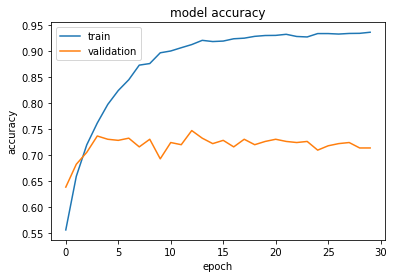

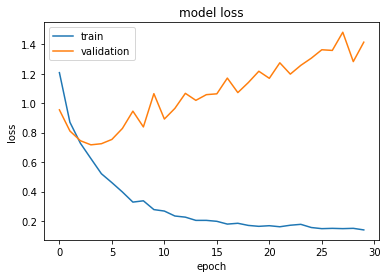

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()